<center>
<img src="https://i.vas3k.blog/7sc.jpg" width="900"> 

# Семинар 5: свёрточные нейросети
</center>
<br>

[Машинное обучение для людей](https://vas3k.ru/blog/machine_learning/)

Пришло время собрать нашу первую свёрточную нейросеть. Будем использовать для этого датасет MNIST. Он маленький, простой и на нём всё быстро работает.

Если хотите испытать свою нейросеть на датасете посложнее, можно взять датасет [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) (Canadian Institute for Advanced Research). Он включает в себя картинки из 10 разных классов: самолёты, машины, птицы, кошки, олени, собаки, лягушки, лошади, корабли, грузовики. Он по аналогии может быть подгружен из торча.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
from tqdm.auto import tqdm

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [4]:
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms as T

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Данные

Загрузим датасет аналогично тому, как мы на прошлом семинаре подгружали MNIST.

In [6]:
transform = T.Compose(
    [
        T.ToTensor(),
#         T.Resize((32, 32)),
        T.Normalize((0.1307,), (0.3081,))
    ]
)

train_dataset = torchvision.datasets.MNIST(
    'MNIST', train=True, download=True, transform=transform
)
val_dataset = torchvision.datasets.MNIST(
    'MNIST', train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False, num_workers=4
)

__Упражнение:__ Объясните зачем нужно нормализовывать картинки. Найдите, где в коде выше происходит их нормализация на отрезок $[-1,1].$ Откуда взялись эти волшебные цифры в нормализаторе?

Нарисуем несколько картинок из тренировочной выборки. 

In [7]:
# вытащим один батч :) 
images, labels = next(iter(train_loader))

In [8]:
images.shape, labels.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

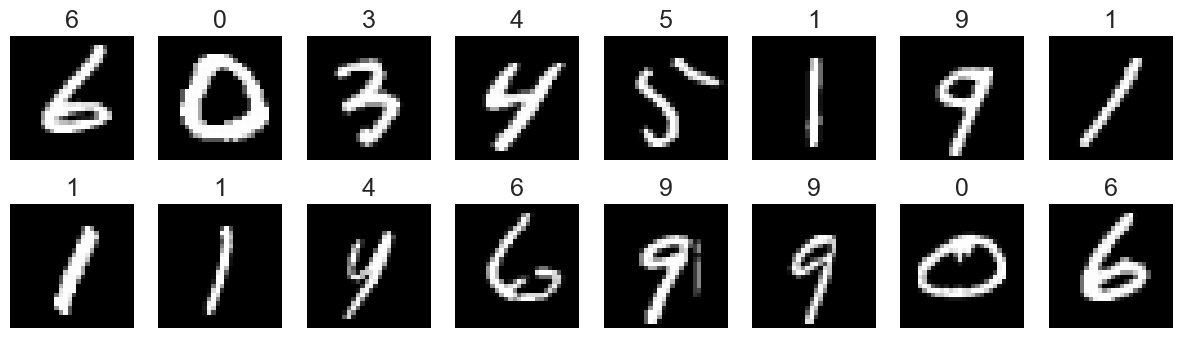

In [9]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(images[k], (1, 2, 0)), cmap='gray')
        ax.set_title(labels[k].item())
        k += 1
plt.show()

# 2. Функции для обучения

Чтобы было проще и быстрее обучать модели, давайте возьмём огромный код для обучения с прошлого семинара и разобьём его на удобные маленькие функции.

__ВАЖНО:__ эти функции не совсем универсальные. Например, вам может захотеться использовать другие функции потерь и другие метрики для отслеживания прогресса обучения. В таком случае, функции придётся немного переписать.

In [10]:
def train_epoch(model, optimizer, criterion):
    loss_log, acc_log = [], []
    
    model.train()
    for batch_num, (x_batch, y_batch) in enumerate(train_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        optimizer.zero_grad()
        
        # x_batch: [batch_size x num_channels x height x width]
        logits = model(x_batch)
        
        # logits: [batch_size x num_classes]
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
            
        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
    return loss_log, acc_log 

In [11]:
def test(model, criterion):
    loss_log, acc_log = [], []
    
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        with torch.no_grad():
            logits = model(x_batch)
            loss = criterion(logits, y_batch)

        pred = torch.max(logits, 1)[1].data.numpy()
        acc = np.mean(pred == y_batch.data.numpy())
        acc_log.append(acc)
        
        loss = loss.item()
        loss_log.append(loss)
    return loss_log, acc_log

In [12]:
def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    
    axs[0].plot(train_losses, label='train')
    
    points = np.array(test_losses)
    axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[0].set_ylabel('loss')

    axs[1].plot(train_accuracies, label='train')
    points = np.array(test_accuracies)
    axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('step')
        ax.legend()

    plt.show()

In [13]:
def train(model, optimizer, criterion, n_epochs, batch_size):
   
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []

    for epoch in range(n_epochs):
        
        train_loss, train_acc = train_epoch(model, optimizer, criterion)
        val_loss, val_acc = test(model, criterion)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        steps = train_dataset.train_labels.shape[0] / batch_size
        
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))
        
        clear_output()
        plot_losses(train_log, val_log, train_acc_log, val_acc_log)  
        
    return {
        'train_logloss': np.mean(train_loss), 'train_accuracy': np.mean(train_acc),
        'val_logloss': val_log[-1], 'val_accuracy': val_acc_log[-1]
    }

# 3. Полносвязная сетка

Соберите полносвязную сеть из 4 слоёв с $128$, $64$, $32$, $10$ нейронами. На всех промежуточных слоях используйте `relu` в качестве функции активации.

In [14]:
INP_SHAPE = np.prod(images.shape[1:])
INP_SHAPE

784

In [15]:
class FC_model(nn.Module):
    def __init__(self, hide_neurons=128, num_classes=10):
        super(FC_model, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(INP_SHAPE, hide_neurons),
            nn.ReLU(),
            nn.Linear(hide_neurons, hide_neurons // 2),
            nn.ReLU(),
            nn.Linear(hide_neurons//2, hide_neurons//4),
            nn.ReLU(),
            nn.Linear(hide_neurons//4, num_classes),
            # nn.Softmax()
        )
        
    def forward(self, x):
        x = nn.Flatten()(x)
        return self.model(x)
    
model = FC_model(256, 10).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

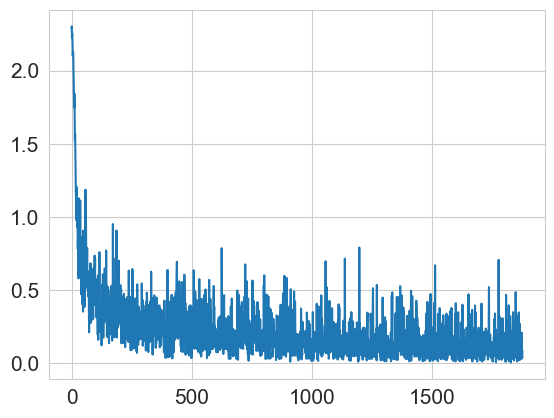

In [16]:
loss_log, acc_log = train_epoch(model, opt, criterion)
plt.plot(loss_log);

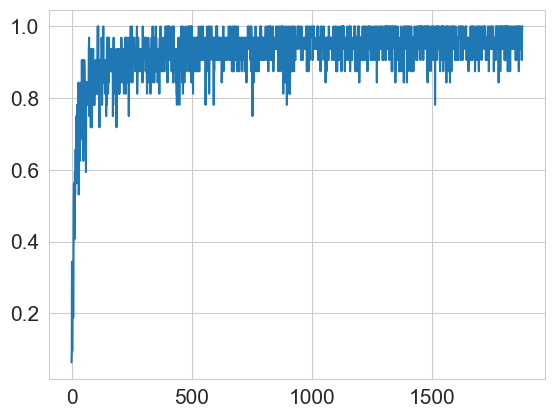

In [17]:
plt.plot(acc_log);

In [18]:
logits = model(images)
loss = criterion(logits, labels)

In [19]:
torch.argmax(logits, dim=1)

tensor([6, 0, 3, 4, 5, 1, 9, 1, 1, 1, 4, 6, 9, 9, 0, 6, 3, 6, 4, 1, 0, 5, 8, 3,
        4, 2, 9, 8, 4, 9, 3, 9])

In [20]:
torch.max(logits, dim=1)

torch.return_types.max(
values=tensor([13.0457, 17.4800,  8.1734, 14.6397,  8.8909,  9.6722, 11.5919, 10.8532,
        11.3251,  9.6198,  8.2970, 10.1641,  8.8126,  9.4300,  6.8522, 15.3217,
        10.0174, 13.2177,  8.3843,  6.8272, 11.5448,  8.2268,  8.3825,  6.0206,
        15.1777,  5.9900, 10.9228,  4.0381, 13.3762,  9.1030, 11.6064, 10.7387],
       grad_fn=<MaxBackward0>),
indices=tensor([6, 0, 3, 4, 5, 1, 9, 1, 1, 1, 4, 6, 9, 9, 0, 6, 3, 6, 4, 1, 0, 5, 8, 3,
        4, 2, 9, 8, 4, 9, 3, 9]))

In [21]:
pred = torch.max(logits, dim=1)[1].numpy()

In [22]:
np.mean(labels.numpy() == pred)

1.0

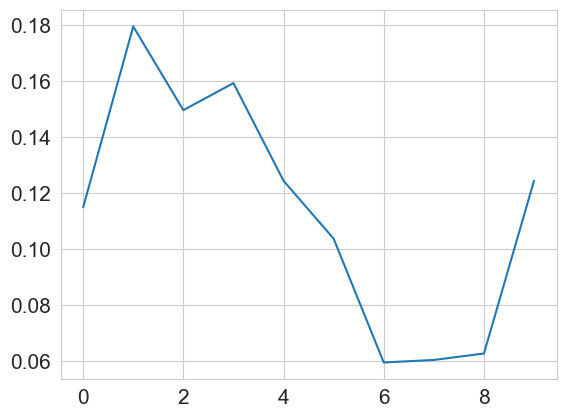

In [23]:
loss_log, acc_log = test(model, criterion)
plt.plot(loss_log);

----

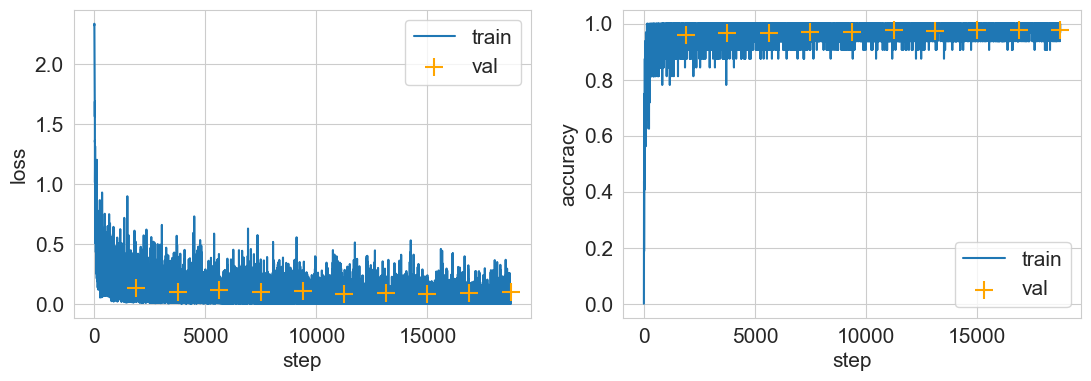

In [24]:
model = FC_model(128, 10).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

history = train(model, opt, criterion, 10, batch_size=32)

In [25]:
print('train_logloss', history['train_logloss'])
print('val_logloss', history['val_logloss'][-1])

print('train_accuracy', history['train_accuracy'])
print('val_accuracy', history['val_accuracy'][-1])

train_logloss 0.02812882980167051
val_logloss 0.10056138541549445
train_accuracy 0.9908166666666667
val_accuracy 0.9761300223214286


Давайте посмотрим на примеры картинок, где модель ошиблась.

In [26]:
def predict(model):
    X, y, logit = [], [], []
    model.eval()
    for batch_num, (x_batch, y_batch) in enumerate(val_loader):
        x_batch.to(device)
        y_batch.to(device)
        
        with torch.no_grad():
            logits = model(x_batch)
            
        X.extend(x_batch.numpy()) # это плохо!
        y.extend(y_batch.numpy())
        logit.extend(torch.max(logits, 1)[1].data.numpy())
    return np.array(X), np.array(y), np.array(logit)

In [27]:
X_test, y_test, y_pred = predict(model)

In [28]:
errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

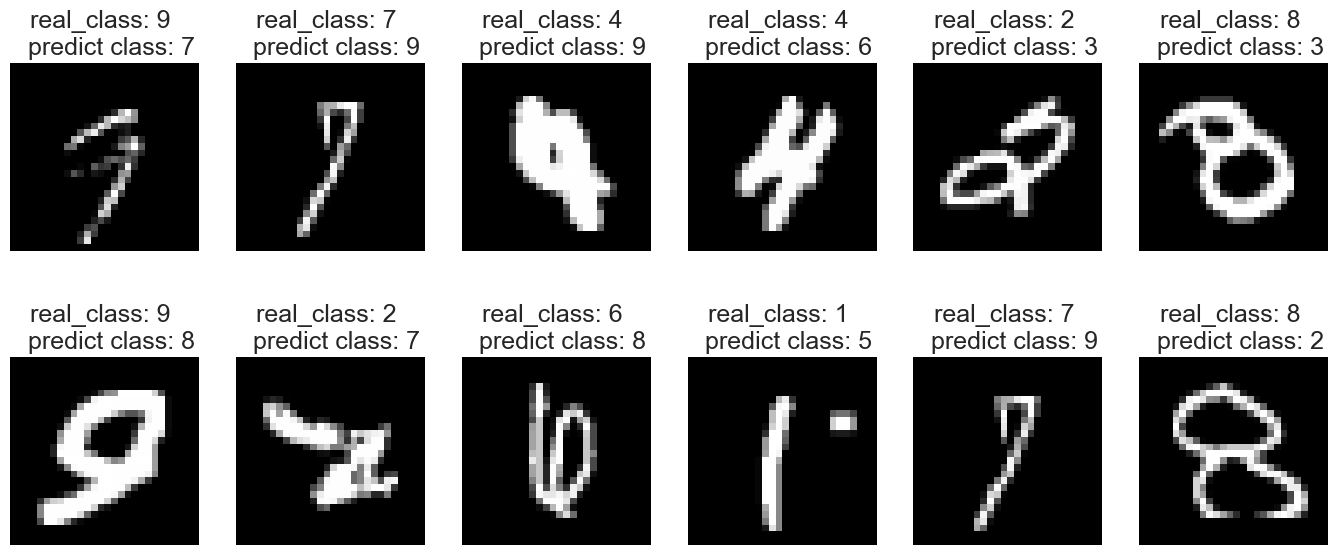

In [29]:
cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

Посмотрим на то, путает ли модель систематически одни классы с другими. Например, лошадей с оленями.  Чтобы лучше было видно занулите диагональ у `confusion_matrix`. 

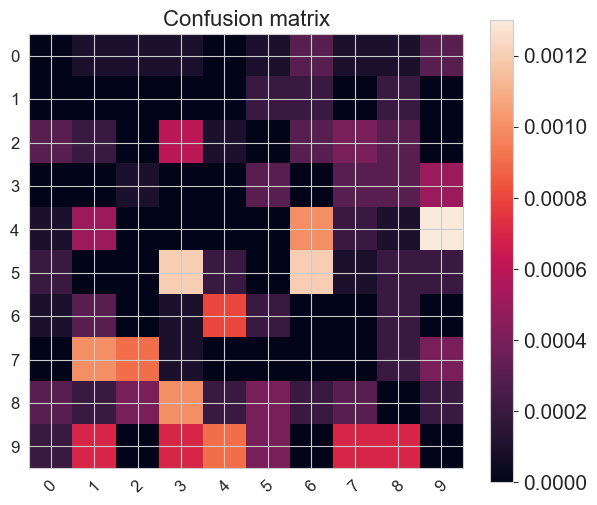

In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred, normalize='all')
cm = cm - np.eye(10)*cm.diagonal()

plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(cm)
plt.xticks(np.arange(10), np.arange(10), rotation=45, fontsize=12)
plt.yticks(np.arange(10), np.arange(10), fontsize=12)
plt.colorbar();

# 4. Свёрточная сеть

Соберите LeNet!

In [31]:
class LeNet(nn.Module):
    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 28 x 28
            nn.Conv2d(in_channels=image_channels, out_channels=6, 
                      kernel_size=5, padding='same'),  # 28 x 28
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, 
                      kernel_size=5, padding='same'),  # 14 x 14
            nn.ReLU(),
            nn.MaxPool2d(2),  # 7 x 7
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=5)  # 3 x 3
        )
        
        self.head = nn.Sequential(
            nn.Linear(in_features=90, out_features=84), # 90
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10)
        )
    
    def forward(self, x):
        # x: B x 1 x 28 x 28
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = nn.Flatten()(out)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out
    
    def get_embedding(self, x):
        out = self.encoder(x)
        return nn.Flatten()(out)

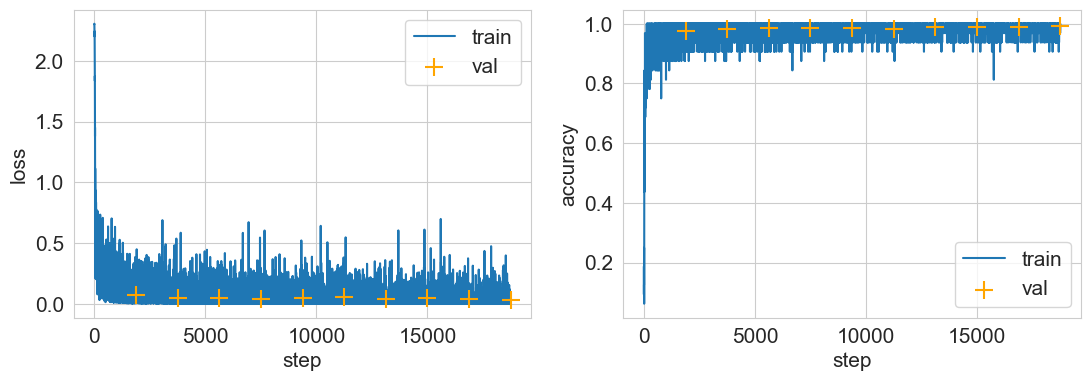

In [32]:
model = LeNet()
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

history = train(model, opt, criterion, 10, batch_size=32)

In [33]:
print('train_logloss', history['train_logloss'])
print('val_logloss', history['val_logloss'][-1])

print('train_accuracy', history['train_accuracy'])
print('val_accuracy', history['val_accuracy'][-1])

train_logloss 0.020567876636958683
val_logloss 0.03387066903524101
train_accuracy 0.9930333333333333
val_accuracy 0.9909638073979592


Посмотрим на ошибки!

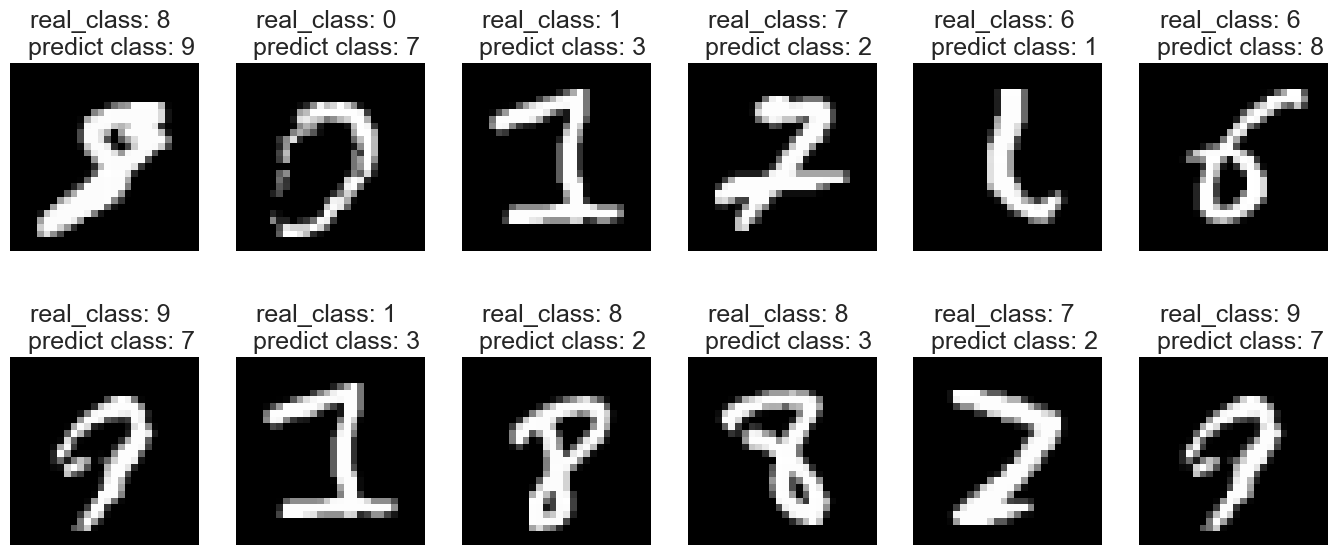

In [34]:
X_test, y_test, y_pred = predict(model)

errors = y_test != y_pred

X_err = X_test[errors]
y_err = y_test[errors]
y_pred_err = y_pred[errors]

cols = 6
rows = 2
fig = plt.figure(figsize=(3 * cols - 1, 4 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_err))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(X_err[random_index], (1, 2, 0)), cmap='gray')
        ax.set_title('real_class: {} \n  predict class: {}'.format(y_err[random_index], y_pred_err[random_index]))
plt.show()

Посчитаем число параметров в нашей нейросетке.

In [ ]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

model = LeNet()
print("Total number of trainable parameters:", count_parameters(model))

__Упражнение:__ Как именнов свёрточной сетке увеличивается поле восприятия? Правда ли, что к `Flatten()`- слою поле восприятия достигает размера картинки? Зачем нам нужно, чтобы это происходило? 

> __Если вам стало скучновато, попробуйте поэкспериментировать с размерами сетки и её архитектурой. Попытайтесь добиться максимально классных результатов.__  [При желании и хорошей регуляризации](https://www.kaggle.com/arianshf/cifar-10-classification-using-cnn) можно выбить Accuracy в районе $0.9,$ а то и выше. Также можете посмотреть, как [похожие архитектуры собрать в pytorch.](https://www.kaggle.com/xcwang21/cifar10-with-mlp-lenet-resnet-for-beginners)


### Различные трюки: 

1. Начните с маленькой сети. Не забывайте прикидывать сколько наблдюдений  тратится на оценку каждого из  параметров. Если величина очень маленькая, не забывайте о регуляризации.
2. Всегда оставляйте часть выборки под валидацию на каждой эпохе.
3. Усложняйте модель, пока качество на валидации не начнёт падать.
4. Не забывайте проскалировать ваши наблюдения для лучшей сходимости.
5. Можно попробовать ещё целую серию различных трюков:
  - Архитектура нейросети
    - Больше/меньше нейронов
    - Больше/меньше слоёв
    - Другие функции активации (tanh, relu, leaky relu, elu etc)
    - Регуляризация (dropout, l1,l2)
  - Более качественная оптимизация
    - Можно попробовать выбрать другой метод оптимизации
    - Можно попробовать менять скорость обучения, моментум и др.
    - Разные начальные значения весов
  - Попробовать собрать больше данных
  - Для случая картинок объёмы данных можно увеличить искусственно с помощью подхода, который называется Data augmemntation

И это далеко не полный список. Обратите внимание, что делать grid_search для больших сеток это довольно времязатратное занятие... 

Логгируйте свои эксперименты. За один прогон пробуйте одно изменение. Иначе будет непонятно какие именно изменения улучшили качество, а какие ухудшили. 

# 5. Эмбеддинги

__«Эмбеддинг» (embedding – вложение)__ — это сопоставление произвольной сущности (например, узла в графе, текста или кусочка картинки) некоторому вектору.

На самом деле вcё глубокое обучение держится на идее эмбеддингов. Один из способов обучить эмбеддинг для картинок — обучить классификатор для какой-то сложной задачи, а затем срезать последние слои. Промежуточный слой будет выдавать вектор какого-то размера для каждой картинки. Эти вектора можно будет использовать в других своих задачах. 

Давайте вытащим представление картинок для тестовой выборки с одного из последних слоёв и построим для неё TSNE-визуализацию.

In [35]:
X_emb, y_test = [],[]

for batch_num, (x_batch, y_batch) in enumerate(val_loader):
    x_batch.to(device)
    y_batch.to(device)

    with torch.no_grad():
        X_emb.extend(model.get_embedding(x_batch).numpy())
    y_test.extend(y_batch.numpy())

In [36]:
X_emb = np.array(X_emb)
y_test = np.array(y_test)

In [37]:
X_emb

array([[-3.104545  , -2.765878  , -0.32301128, ...,  1.4849968 ,
         1.9374236 ,  3.937585  ],
       [ 5.2205257 ,  2.5212994 , -2.0774212 , ..., -0.88519067,
         0.4659496 ,  0.30658245],
       [ 3.1357453 ,  3.28602   ,  0.5981387 , ..., -0.5621165 ,
         0.82554567,  1.0987173 ],
       ...,
       [-2.3291092 , -2.1796246 ,  1.5750655 , ..., -1.059371  ,
         0.6252111 ,  4.635647  ],
       [ 0.51582193, -3.1579418 , -7.8338194 , ...,  1.2810134 ,
         0.58265746,  2.4738078 ],
       [ 3.5557337 ,  3.7317717 ,  3.6683748 , ..., -0.1906339 ,
         2.296113  ,  4.9370418 ]], dtype=float32)

In [38]:
X_emb.shape # N x emb_size

(10000, 90)

Визуализируем данные с помощью TSNE. Вы знаете этот метод визуализации данных из курса по машинному обучению. Если подзабыли как он работает, почитайте [статью на DistillPub.](https://distill.pub/2016/misread-tsne/) Внутри sklearn есть реализация TSNE, но она не такая эффективная как [библиотека MulticoreTSNE,](https://github.com/DmitryUlyanov/Multicore-TSNE) в которой метод можно распараллелить.

In [39]:
# !pip install MulticoreTSNE

In [40]:
# from MulticoreTSNE import MulticoreTSNE as TSNE
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_emb)

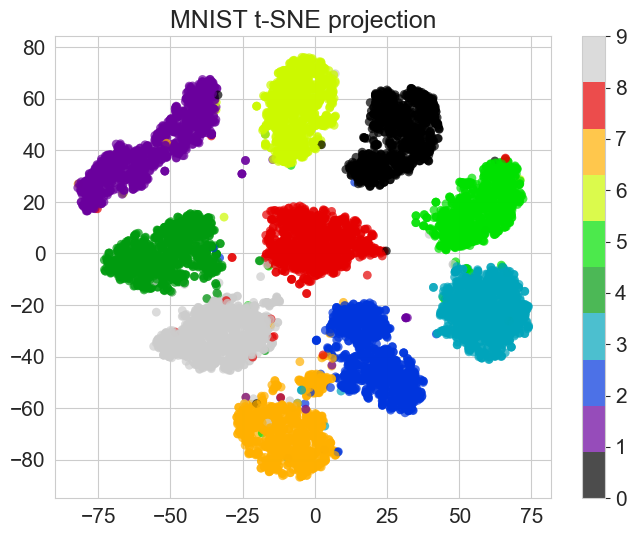

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_test, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.colorbar()
plt.title('MNIST t-SNE projection');

Видно, что эмбеддинги впитали в себя информацию о том, к какому классу относится какая картинка. В больших технологических компаниях с картинками часто работают следующим образом. 

- Каким-то методом учат огромную нейросеть, которая хорошо понимает что изображено на картинках. Такую большую сетку называют __тушей__ или __тушкой.__
- Берут эмбеддинги с одного из последних слоёв и доучивают на них маленькие модели. Например, модели для классификации. Их называют __головами.__ 
- Эмбеддинги картинок посылают на вход другим моделям. Например, в градиентный бустинг. Обычно фичи, полученные из нейросети называют __нейросетевыми фичами.__ 

Конечно же это не единственный способ получать для картинок эмбеддинги. Дальше мы будем обсуждать и другие методы. 


# 6. Ещё данные!

In [42]:
transform = T.Compose([T.ToTensor(), T.Resize((28, 28))])

train_set = torchvision.datasets.SVHN('SVHN', transform=None, split='train', download=True)
test_set = torchvision.datasets.SVHN('SVHN', transform=None, split='test', download=True)

Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [43]:
img, label = train_set[0]
label

1

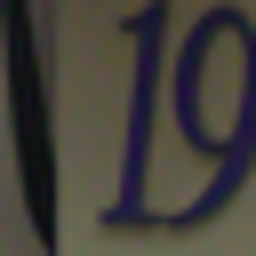

In [44]:
img.resize((256, 256))

In [45]:
train_set = torchvision.datasets.SVHN('SVHN', transform=transform, split='train', download=True)
val_set = torchvision.datasets.SVHN('SVHN', transform=transform, split='test', download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=False)

Using downloaded and verified file: SVHN/train_32x32.mat
Using downloaded and verified file: SVHN/test_32x32.mat


In [46]:
images, labels = next(iter(train_loader))

In [47]:
labels[1]

tensor(1)

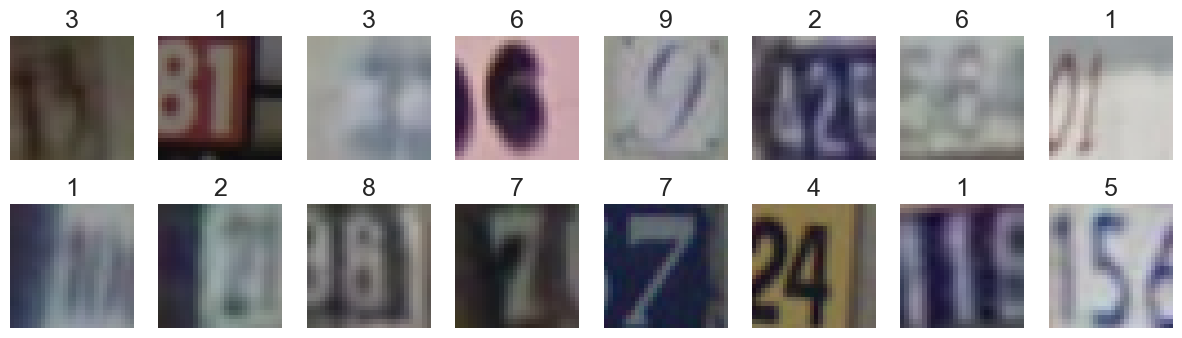

In [48]:
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
k = 0
for i in range(cols):
    for j in range(rows):
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(np.transpose(images[k], (1, 2, 0)), cmap='gray')
        ax.set_title(labels[k].item())
        k += 1
plt.show()

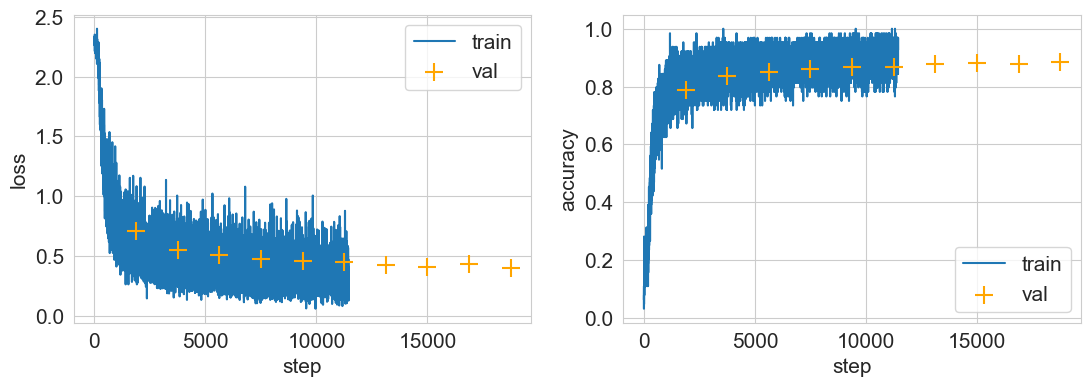

In [49]:
NUM_EPOCHS = 20

model = LeNet(image_channels=3).to(device)
criterion = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

history = train(model, opt, criterion, 10, batch_size=32)

Такие всратые картинки получились из-за того что step посчитался по предыдущему датасету :D